Data fields:

Access_ID - Unique identification of the user access to the website

Date - Website visit date

AccountMng_Pages - Number of pages visited by the user about account management

AccountMng_Duration - Total amount of time (seconds) spent by the user on account management related pages

FAQ_Pages - Number of pages visited by the user about frequently asked questions, shipping information and company related pages

FAQ_Duration - Total amount of time (seconds) spent by the user on FAQ pages

Product_Pages - Number of pages visited by the user about products and services offered by the company

Product_Duration - Total amount in time (seconds) spent by the user on products and services related pages

GoogleAnalytics_BounceRate - Average bounce rate value of the pages visited by the user, provided by google analytics

GoogleAnalytics_ExitRate - Average exit rate value of the pages visited by the user, provided by google analytics

GoogleAnalytics_PageValue - Average page value of the pages visited by the user, provided by google analytics

OS - Operating System of the user

Browser - Browser used to access the webpage

Country - The country of the user

Type_of_Traffic - Traffic Source by which the user has accessed the website (e.g., email, banner, direct)

Type_of_Visitor - User type as "New access", "Returner" or "Other"

Buy - Class label indicating if the user finalized their actions in the website with a transaction

In [269]:
import pandas as pd
import numpy as np
import datetime
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import metrics


In [353]:
# importing datasets
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
sub_smp = pd.read_csv('../data/sample_submission.csv')

In [354]:
# set access ID as index
df_train.set_index('Access_ID', inplace = True)

In [355]:
round(df_train.Buy.mean(),3)*100 # we have an average conversion rate of 15.5%

15.5

In [356]:
# from object to date
df_train.Date = df_train.Date.apply(lambda x: datetime.datetime.strptime(x, "%d-%b-%y"))

In [357]:
#confirm
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 102863333 to 798444008
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        9999 non-null   datetime64[ns]
 1   AccountMng_Pages            9999 non-null   int64         
 2   AccountMng_Duration         9999 non-null   float64       
 3   FAQ_Pages                   9999 non-null   int64         
 4   FAQ_Duration                9999 non-null   float64       
 5   Product_Pages               9999 non-null   int64         
 6   Product_Duration            9999 non-null   float64       
 7   GoogleAnalytics_BounceRate  9999 non-null   float64       
 8   GoogleAnalytics_ExitRate    9999 non-null   float64       
 9   GoogleAnalytics_PageValue   9999 non-null   float64       
 10  OS                          9999 non-null   object        
 11  Browser                     9999 non-null  

### Data Exploration

In [229]:

## distribution of categorical variables

# cat_vars = ['OS','Browser','Country','Type_of_Traffic','Type_of_Visitor','WDay_Access','Month_Access','Day_Access']

# # Prepare figure. Create individual axes where each bar plot will be placed
# fig, axes = plt.subplots(2, ceil(len(cat_vars) / 2), figsize=(30, 15))

# # Plot data
# # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
# for ax, feat in zip(axes.flatten(), cat_vars): # Notice the zip() function and flatten() method
#     ax.bar(height=list(df_train[feat].value_counts()), x=list(df_train[feat].value_counts().index))
#     ax.set_title(feat, y=-0.15)
# plt.show()
    


In [230]:
# Prepare figure. Create individual axes where each bar plot will be placed
# fig, axes = plt.subplots(2, ceil(len(cat_vars) / 2), figsize=(30, 15))

# # Plot data
# # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
# for ax, feat in zip(axes.flatten(), cat_vars): # Notice the zip() function and flatten() method
#     ax.bar(height=list(df_train.groupby(feat).Buy.agg('mean')*100), x=list(df_train[feat].value_counts().index))
#     ax.set_title(feat, y=-0.15)
# plt.show()
    

In [358]:
df_train.head().T

Access_ID,102863333,103117814,103201891,103226087,103234445
Date,2020-03-21 00:00:00,2020-05-20 00:00:00,2020-12-04 00:00:00,2020-12-22 00:00:00,2020-11-24 00:00:00
AccountMng_Pages,0,0,0,0,0
AccountMng_Duration,0.0,0.0,0.0,0.0,0.0
FAQ_Pages,0,0,0,0,2
FAQ_Duration,0.0,0.0,0.0,0.0,386.0
Product_Pages,3,23,8,9,36
Product_Duration,64.0,684.5,95.0,608.75,1609.9397
GoogleAnalytics_BounceRate,0.0,0.0217,0.025,0.0,0.0
GoogleAnalytics_ExitRate,0.0667,0.0449,0.0583,0.025,0.0093
GoogleAnalytics_PageValue,0.0,0.0,0.0,42.4225,12.5033


In [359]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
AccountMng_Pages,9999.0,2.324232,3.340676,0.0,0.0000,1.0000,4.00000,27.0000
AccountMng_Duration,9999.0,81.205854,179.715545,0.0,0.0000,7.5000,92.20835,3398.7500
FAQ_Pages,9999.0,0.508051,1.279390,0.0,0.0000,0.0000,0.00000,24.0000
FAQ_Duration,9999.0,34.559101,139.796989,0.0,0.0000,0.0000,0.00000,2549.3750
Product_Pages,9999.0,31.685869,44.550277,0.0,7.0000,18.0000,38.00000,705.0000
Product_Duration,9999.0,1199.769430,1958.276304,0.0,183.5625,599.0000,1470.27080,63973.5222
GoogleAnalytics_BounceRate,9999.0,0.022305,0.048776,0.0,0.0000,0.0032,0.01680,0.2000
GoogleAnalytics_ExitRate,9999.0,0.043181,0.048845,0.0,0.0143,0.0251,0.05000,0.2000
GoogleAnalytics_PageValue,9999.0,5.963120,18.753626,0.0,0.0000,0.0000,0.00000,361.7637
Browser,9999.0,2.352535,1.715698,1.0,2.0000,2.0000,2.00000,13.0000


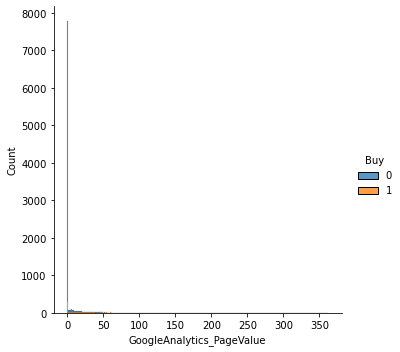

In [514]:
sns.displot(df_train, x='GoogleAnalytics_PageValue', discrete=True, multiple="stack", hue='Buy')
plt.show()

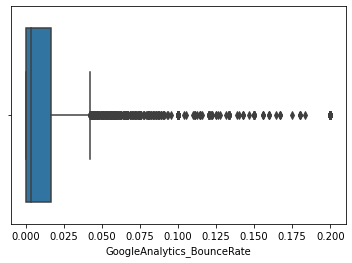

In [421]:
sns.boxplot(data=df_train, x='GoogleAnalytics_BounceRate')
plt.show()

In [108]:
## function to plot categorical variables distribution and conversion by each of the levels

def plot_feat (df,feat):
    
    dist = pd.Series(df[feat].value_counts(normalize=True), name='Distribution')
    prop = pd.Series(df.groupby(feat).Buy.agg('mean'), name='Conversion')
    dt = pd.concat([dist,prop], axis=1)
    
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    dt['Distribution'].plot(kind='bar', color='tab:blue', ax=ax, width=0.4, position=1)
    dt['Conversion'].plot(kind='bar', color='tab:orange', ax=ax2, width=0.4, position=0)

    ax.set_ylabel('Distribution (%)')
    ax2.set_ylabel('Conversion (%)')

    plt.show()
    

In [ ]:
cat_vars = ['OS','Browser','Country','Type_of_Traffic','Type_of_Visitor','WDay_Access','Month_Access','Day_Access']

In [543]:
plot_feat(df_train, 'Day_Access')

KeyError: 'Day_Access'

### Pre-processing

In [548]:
df_process = df_train.copy()

In [549]:
df_process.isna().sum()

Date                          0
AccountMng_Pages              0
AccountMng_Duration           0
FAQ_Pages                     0
FAQ_Duration                  0
Product_Pages                 0
Product_Duration              0
GoogleAnalytics_BounceRate    0
GoogleAnalytics_ExitRate      0
GoogleAnalytics_PageValue     0
OS                            0
Browser                       0
Country                       0
Type_of_Traffic               0
Type_of_Visitor               0
Buy                           0
dtype: int64

In [482]:
# check if we have duplicates
df_process.duplicated().sum()

14

In [550]:
# remove duplicates
df_process.drop_duplicates(keep='first', inplace=True)

In [484]:
# confirm
df_process.duplicated().sum()

0

In [551]:
df_process = df_process.loc[
    (df_process['AccountMng_Pages']<= 20)
    &
    (df_process['AccountMng_Duration']<=2000)
    &
    (df_process['FAQ_Pages']<= 20)
    &
    (df_process['FAQ_Duration']<= 2000)
    &
    (df_process['Product_Pages'] <= 550)
    &
    (df_process['Product_Duration'] <= 20000)
]

In [552]:
print("We kept %0.2f percent of the original data" % (df_process.shape[0]/df_train.shape[0]*100))

We kept 99.58 percent of the original data


In [553]:
df_process.Browser.value_counts(normalize=True)

2     0.647986
1     0.199257
4     0.059857
5     0.036155
6     0.013860
10    0.013056
8     0.011349
3     0.008135
13    0.005122
7     0.004118
12    0.000803
11    0.000301
Name: Browser, dtype: float64

#### Build new variables

In [487]:
# get details from the date
df_process['Month_Access'] = df_process.Date.apply(lambda x: x.month)
df_process['Day_Access'] = df_process.Date.apply(lambda x: x.day)
df_process['WDay_Access'] = df_process.Date.apply(lambda x: x.weekday()) ## monday is 0

# calculate new variables

# total number of pages visited and total durantion of visits
df_process['Total_Pages'] = df_process['AccountMng_Pages']+df_process['FAQ_Pages']+df_process['Product_Pages']
df_process['Total_Duration'] = df_process['AccountMng_Duration']+df_process['FAQ_Duration']+df_process['Product_Duration']

# proportion of visits by each pages and duration
df_process['Prop_AccountMng_Pages'] = df_process['AccountMng_Pages']/df_process['Total_Pages']
df_process['Prop_FAQ_Pages'] = df_process['FAQ_Pages']/df_process['Total_Pages']
df_process['Prop_Product_Pages'] = df_process['Product_Pages']/df_process['Total_Pages']

df_process['Prop_AccountMng_Duration'] = df_process['AccountMng_Duration']/df_process['Total_Duration']
df_process['Prop_FAQ_Duration'] = df_process['FAQ_Duration']/df_process['Total_Duration']
df_process['Prop_Product_Duration'] = df_process['Product_Duration']/df_process['Total_Duration']

# averages times spent in each page
df_process['Avg_AccountMng_Duration'] = df_process['AccountMng_Duration']/df_process['AccountMng_Pages']
df_process['Avg_FAQ_Duration'] = df_process['FAQ_Duration']/df_process['FAQ_Pages']
df_process['Avg_Product_Duration'] = df_process['Product_Duration']/df_process['Product_Pages']

# total average
df_process['Avg_Duration'] = df_process['Total_Duration']/df_process['Total_Pages']

In [488]:
## encoding

dummy_os = pd.get_dummies(df_process['OS'], prefix='OS')
dummy_browser = pd.get_dummies(df_process['Browser'], prefix='Browser')
dummy_country = pd.get_dummies(df_process['Country'], prefix='Country')
dummy_traffic = pd.get_dummies(df_process['Type_of_Traffic'], prefix='Traffic')
dummy_visitor = pd.get_dummies(df_process['Type_of_Visitor'], prefix='Visitor')
dummy_wday = pd.get_dummies(df_process['WDay_Access'], prefix='Wday')

df_process = pd.concat([df_process, dummy_os, dummy_browser, dummy_country, dummy_traffic, dummy_visitor, dummy_wday], axis=1)

In [489]:
df_process.drop(['Date','OS','Browser','Country','Type_of_Traffic','Type_of_Visitor','WDay_Access'], axis=1, inplace=True)

In [490]:
df_process.head()

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Buy,...,Visitor_New_Access,Visitor_Other,Visitor_Returner,Wday_0,Wday_1,Wday_2,Wday_3,Wday_4,Wday_5,Wday_6
Access_ID,,,,,,,,,,,,,,,,,,,,,
102863333,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,0,...,0,0,1,0,0,0,0,0,1,0
103117814,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,0,...,0,0,1,0,0,1,0,0,0,0
103201891,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,0,...,0,0,1,0,0,0,0,1,0,0
103226087,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,1,...,0,0,1,0,1,0,0,0,0,0
103234445,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,1,...,0,0,1,0,1,0,0,0,0,0


In [491]:
aa = df_process.loc[df_process['Avg_FAQ_Duration'].isna(), ['FAQ_Pages','FAQ_Duration','Avg_FAQ_Duration']]

In [472]:
aa

,FAQ_Pages,FAQ_Duration,Avg_FAQ_Duration
Access_ID,,,
102863333,0,0.0,NaN
103117814,0,0.0,NaN
103201891,0,0.0,NaN
103226087,0,0.0,NaN
103237767,0,0.0,NaN
...,...,...,...
798164578,0,0.0,NaN
798314158,0,0.0,NaN
798339820,0,0.0,NaN


In [492]:
df_process.fillna(0, inplace=True)

In [496]:
X = df_process.drop('Buy',axis=1)
y = df_process['Buy']

In [105]:
## undersampling
# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy='majority')
# # fit and apply the transform
# X_under, y_under = undersample.fit_resample(X, y)

In [107]:
# y_under.mean()*100

50.0

In [497]:
#X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42, stratify=y_under)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [476]:
print(y_train.mean())
print(y_test.mean())

0.1551650235747964
0.15533333333333332


In [498]:
print(X_train.shape)
print(X_test.shape)

(6969, 77)
(2988, 77)


In [ ]:
# Decision Tree

In [532]:
Decisiontree = DecisionTreeClassifier(max_depth=4, min_samples_leaf = 0.01, random_state=54).fit(X_train, y_train)

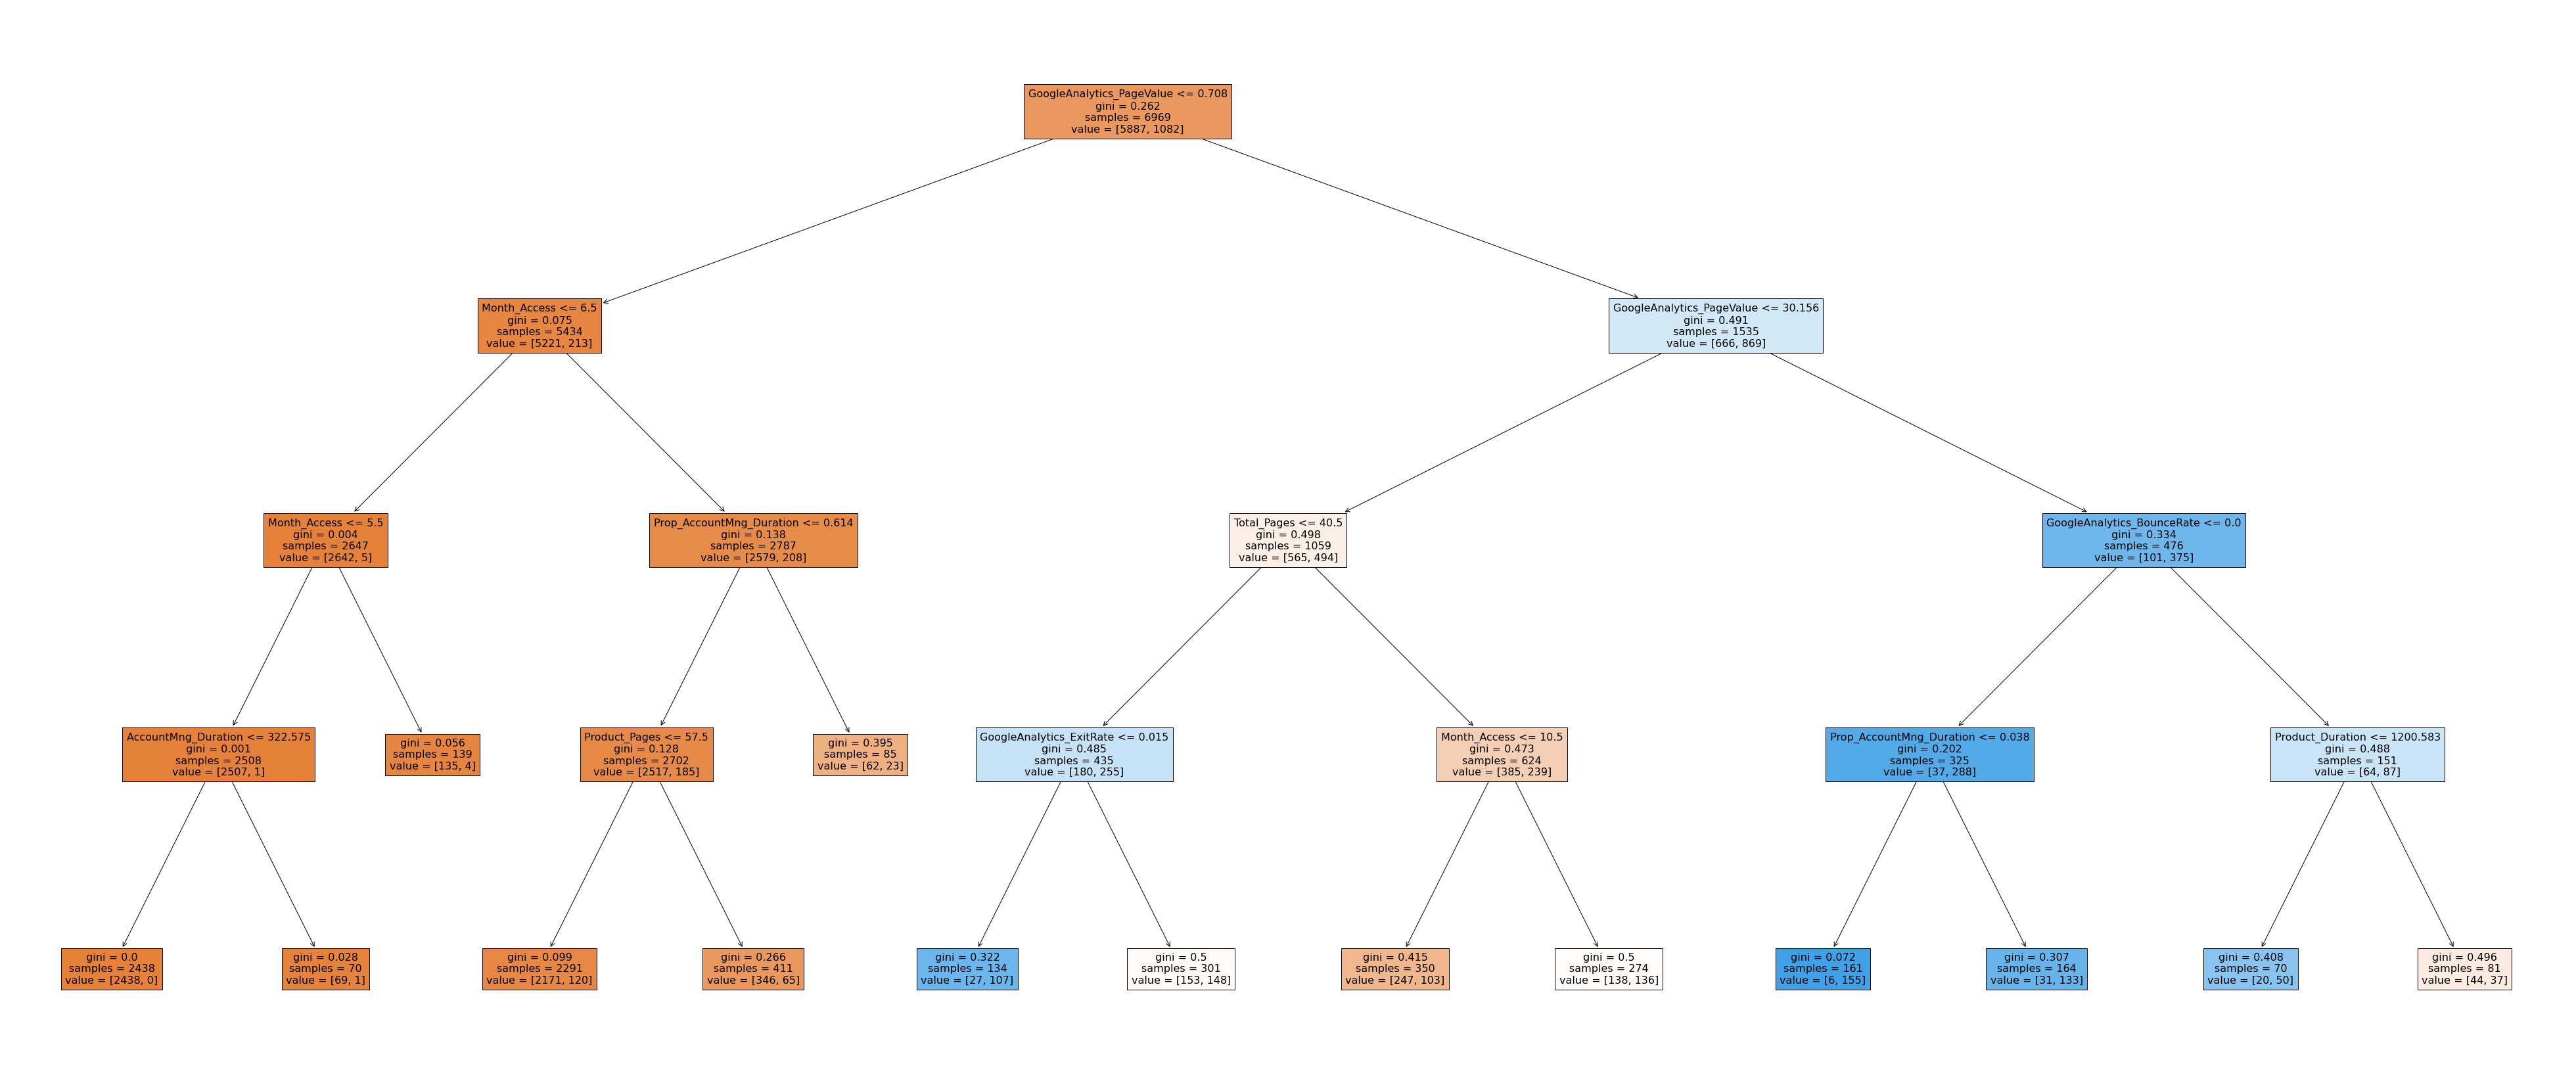

In [533]:
fig = plt.figure(figsize=(70,30))
tree.plot_tree(Decisiontree, feature_names=X_train.columns, filled=True)
plt.show()

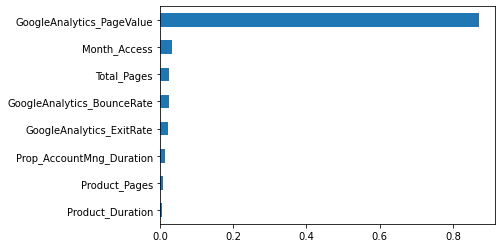

In [541]:
dt_featimp = pd.Series(Decisiontree.feature_importances_, index=X_train.columns)
dt_featimp = dt_featimp[dt_featimp>=0.001]
dt_featimp.sort_values().plot(kind='barh')
plt.show()

In [537]:
DT_train_score = Decisiontree.predict_proba(X_train)[:,1]
DT_train_class = np.where(DT_train_score>=0.155,1,0)
DT_test_score = Decisiontree.predict_proba(X_test)[:,1]
DT_test_class = np.where(DT_test_score>=0.155,1,0)

In [540]:
print('------ Train metrics' + '\n')
print('Precision: '+ str(round(metrics.precision_score(y_train, DT_train_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, DT_train_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, DT_train_class),3)))

print('\n')
print('------ Validation metrics' + '\n')

print('Precision: '+ str(round(metrics.precision_score(y_test, DT_test_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, DT_test_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, DT_test_class),3)))


------ Train metrics

Precision: 0.471
Recall: 0.884
F1 Score: 0.615


------ Validation metrics

Precision: 0.472
Recall: 0.869
F1 Score: 0.612


In [ ]:
# Ensemble models

In [605]:
RandomForest = RandomForestClassifier(n_estimators = 1000, max_samples=0.8, random_state=98).fit(X_train,y_train)

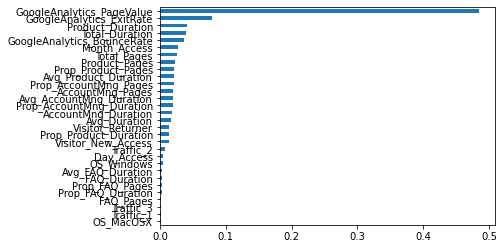

In [599]:
RF_feat_imprt = pd.Series(RandomForest.feature_importances_, index=X.columns).sort_values()
RF_feat_imprt[RF_feat_imprt>0.001].plot(kind='barh')
plt.show()

In [606]:
RF_train_score = RandomForest.predict_proba(X_train)[:,1]
RF_train_class = np.where(RF_train_score>=0.155,1,0)
RF_test_score = RandomForest.predict_proba(X_test)[:,1]
RF_test_class = np.where(RF_test_score>=0.155,1,0)

In [607]:
print('------ Train metrics' + '\n')
print('Precision: '+ str(round(metrics.precision_score(y_train, RF_train_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, RF_train_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, RF_train_class),3)))

print('\n')
print('------ Validation metrics' + '\n')

print('Precision: '+ str(round(metrics.precision_score(y_test, RF_test_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, RF_test_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, RF_test_class),3)))


------ Train metrics

Precision: 0.71
Recall: 1.0
F1 Score: 0.831


------ Validation metrics

Precision: 0.456
Recall: 0.888
F1 Score: 0.602


In [ ]:
## Gradient Boosting

In [554]:
f1_train = []
f1_test = []
sizes = [0.01, 0.03, 0.05]

for size in sizes:
    GradientBoost = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=3, random_state=93, min_samples_leaf = size)
    GradientBoost.fit(X_train, y_train)
    
    train_pred = np.where(GradientBoost.predict_proba(X_train)[:,1]>=0.16,1,0)
    test_pred = np.where(GradientBoost.predict_proba(X_test)[:,1]>=0.16,1,0)
    
    
    f1_train.append(metrics.f1_score(y_train,train_pred))
    f1_test.append(metrics.f1_score(y_test,test_pred))


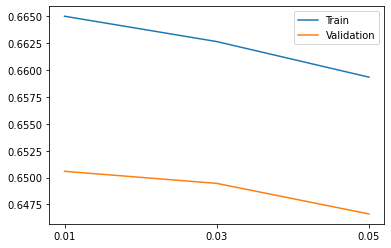

In [555]:
plt.plot(sizes, f1_train, label='Train')
plt.plot(sizes, f1_test, label = 'Validation')
plt.xticks(sizes)
plt.legend()
plt.show()

In [581]:
estimator = GradientBoost.estimators_[0][0]

In [582]:
type(estimator)

sklearn.tree._classes.DecisionTreeRegressor

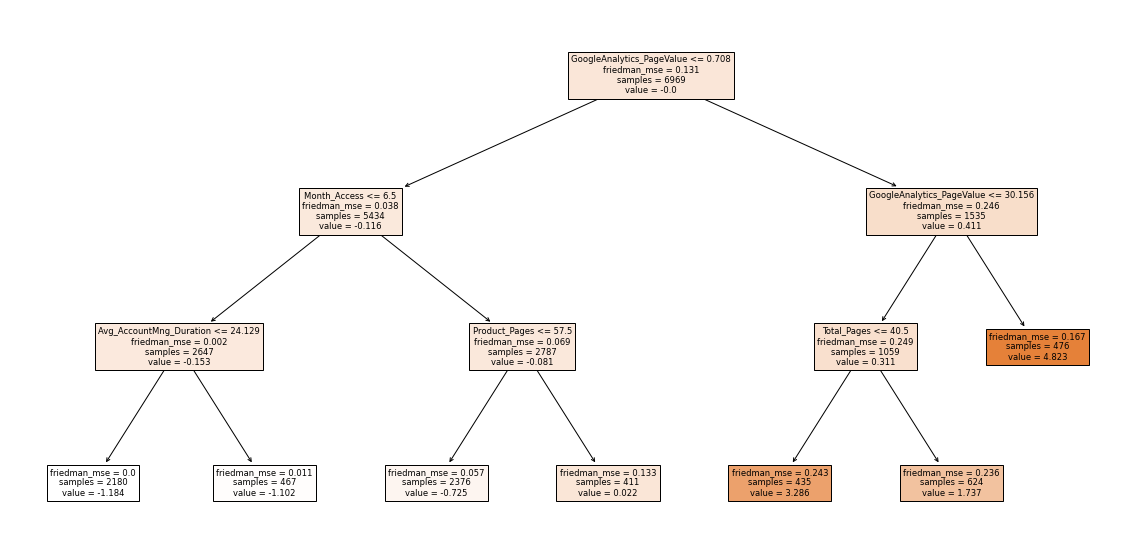

In [588]:
fig = plt.figure(figsize=(20,10))
tree.plot_tree(estimator, feature_names=X_train.columns, filled=True)
plt.show()

In [242]:
f1_train = []
f1_test = []
rates = [0.001, 0.01, 0.015]

for rate in rates:
    GradientBoost = GradientBoostingClassifier(n_estimators=500, learning_rate=rate, max_depth=3, random_state=93, min_samples_leaf = 0.2)
    GradientBoost.fit(X_train, y_train)
    
    train_pred = np.where(GradientBoost.predict_proba(X_train)[:,1]>=0.16,1,0)
    test_pred = np.where(GradientBoost.predict_proba(X_test)[:,1]>=0.16,1,0)
    
    
    f1_train.append(metrics.f1_score(y_train,train_pred))
    f1_test.append(metrics.f1_score(y_test,test_pred))


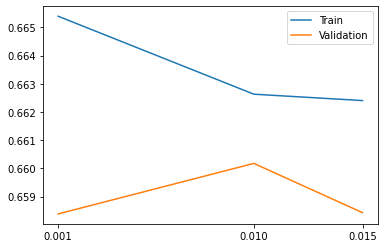

In [243]:
plt.plot(rates, f1_train, label='Train')
plt.plot(rates, f1_test, label = 'Validation')
plt.xticks(rates)
plt.legend()
plt.show()

In [251]:
f1_train = []
f1_test = []
trees = [400, 500, 600]

for tree in trees:
    GradientBoost = GradientBoostingClassifier(n_estimators=tree, learning_rate=0.01, max_depth=3, random_state=93, min_samples_leaf = 0.2)
    GradientBoost.fit(X_train, y_train)
    
    train_pred = np.where(GradientBoost.predict_proba(X_train)[:,1]>=0.16,1,0)
    test_pred = np.where(GradientBoost.predict_proba(X_test)[:,1]>=0.16,1,0)
    
    
    f1_train.append(metrics.f1_score(y_train,train_pred))
    f1_test.append(metrics.f1_score(y_test,test_pred))

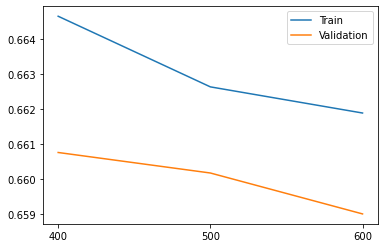

In [252]:
plt.plot(trees, f1_train, label='Train')
plt.plot(trees, f1_test, label = 'Validation')
plt.xticks(trees)
plt.legend()
plt.show()

In [255]:
f1_train = []
f1_test = []
depths = [3, 4, 5, 6]

for depth in depths:
    GradientBoost = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=depth, random_state=93, min_samples_leaf = 0.1)
    GradientBoost.fit(X_train, y_train)
    
    train_pred = np.where(GradientBoost.predict_proba(X_train)[:,1]>=0.16,1,0)
    test_pred = np.where(GradientBoost.predict_proba(X_test)[:,1]>=0.16,1,0)
    
    
    f1_train.append(metrics.f1_score(y_train,train_pred))
    f1_test.append(metrics.f1_score(y_test,test_pred))

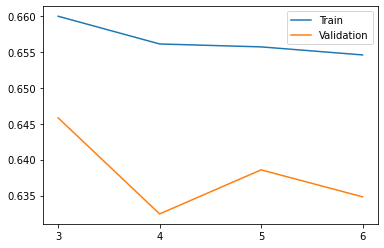

In [256]:
plt.plot(depths, f1_train, label='Train')
plt.plot(depths, f1_test, label = 'Validation')
plt.xticks(depths)
plt.legend()
plt.show()

In [122]:
#scores = cross_val_score(GradientBoost1, X_train, y, cv=5, scoring='f1')
# print(scores)
# print("%0.2f f1_score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [590]:
GradientBoost_f = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=3, random_state=45, min_samples_leaf = 0.2)
GradientBoost_f.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=0.2,
                           n_estimators=500, random_state=45)

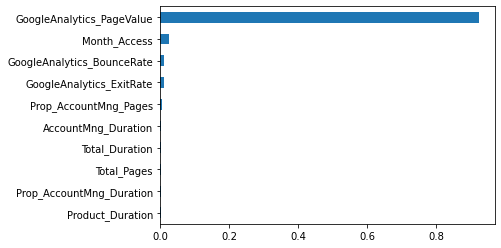

In [598]:
GB_feat_imprt = pd.Series(GradientBoost_f.feature_importances_, index=X.columns).sort_values()
GB_feat_imprt[GB_feat_imprt>0.001].plot(kind='barh')
plt.show()

In [593]:
GB_feat_imprt

AccountMng_Pages              0.000000
Traffic_4                     0.000000
Traffic_3                     0.000000
Country_United Kingdom        0.000000
Country_Switzerland           0.000000
                                ...   
Prop_AccountMng_Pages         0.004585
GoogleAnalytics_ExitRate      0.013063
GoogleAnalytics_BounceRate    0.013136
Month_Access                  0.026326
GoogleAnalytics_PageValue     0.924365
Length: 77, dtype: float64

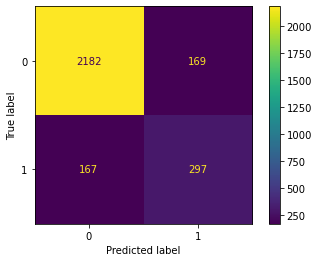

In [139]:
metrics.plot_confusion_matrix(GradientBoost_f, X_test, y_test)  

In [140]:
GB_train_pred = GradientBoost_f.predict(X_train)
GB_train_score = GradientBoost_f.predict_proba(X_train)[:,1]

In [141]:
print('Precision: '+ str(round(metrics.precision_score(y_train, GB_train_pred),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, GB_train_pred),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, GB_train_pred),3)))

Precision: 0.674
Recall: 0.653
F1 Score: 0.663


In [142]:
GB_pred = GradientBoost_f.predict(X_test)
GB_score = GradientBoost_f.predict_proba(X_test)[:,1]

In [143]:
print('Precision: '+ str(round(metrics.precision_score(y_test, GB_pred),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, GB_pred),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, GB_pred),3)))


Precision: 0.637
Recall: 0.64
F1 Score: 0.639


### Submission 

In [213]:
## prepair test data

# set access ID as index
df_test.set_index('Access_ID', inplace = True)

In [214]:
df_test.isna().sum()

Date                          0
AccountMng_Pages              0
AccountMng_Duration           0
FAQ_Pages                     0
FAQ_Duration                  0
Product_Pages                 0
Product_Duration              0
GoogleAnalytics_BounceRate    0
GoogleAnalytics_ExitRate      0
GoogleAnalytics_PageValue     0
OS                            0
Browser                       0
Country                       0
Type_of_Traffic               0
Type_of_Visitor               0
dtype: int64

In [215]:

# data for submission
df_test.Date = df_test.Date.apply(lambda x: datetime.datetime.strptime(x, "%d-%b-%y"))

# get details from the date
df_test['Month_Access'] = df_test.Date.apply(lambda x: x.month)
df_test['Day_Access'] = df_test.Date.apply(lambda x: x.day)
df_test['WDay_Access'] = df_test.Date.apply(lambda x: x.weekday()) ## monday is 0

# total number of pages visited and total durantion of visits
df_test['Total_Pages'] = df_test['AccountMng_Pages']+df_test['FAQ_Pages']+df_test['Product_Pages']
df_test['Total_Duration'] = df_test['AccountMng_Duration']+df_test['FAQ_Duration']+df_test['Product_Duration']

# proportion of visits by each pages and duration
df_test['Prop_AccountMng_Pages'] = df_test['AccountMng_Pages']/df_test['Total_Pages']
df_test['Prop_FAQ_Pages'] = df_test['FAQ_Pages']/df_test['Total_Pages']
df_test['Prop_Product_Pages'] = df_test['Product_Pages']/df_test['Total_Pages']

df_test['Prop_AccountMng_Duration'] = df_test['AccountMng_Duration']/df_test['Total_Duration']
df_test['Prop_FAQ_Duration'] = df_test['FAQ_Duration']/df_test['Total_Duration']
df_test['Prop_Product_Duration'] = df_test['Product_Duration']/df_test['Total_Duration']

# averages times spent in each page
df_test['Avg_AccountMng_Duration'] = df_test['AccountMng_Duration']/df_test['AccountMng_Pages']
df_test['Avg_AccountMng_Duration'] = df_test['FAQ_Duration']/df_test['FAQ_Pages']
df_test['Avg_AccountMng_Duration'] = df_test['Product_Duration']/df_test['Product_Pages']

# total average
df_test['Avg_Duration'] = df_test['Total_Duration']/df_test['Total_Pages']

## encoding

dummy_os = pd.get_dummies(df_test['OS'], prefix='OS')
dummy_browser = pd.get_dummies(df_test['Browser'], prefix='Browser')
dummy_country = pd.get_dummies(df_test['Country'], prefix='Country')
dummy_traffic = pd.get_dummies(df_test['Type_of_Traffic'], prefix='Traffic')
dummy_visitor = pd.get_dummies(df_test['Type_of_Visitor'], prefix='Visitor')
dummy_wday = pd.get_dummies(df_test['WDay_Access'], prefix='Wday')

df_test = pd.concat([df_test, dummy_os, dummy_browser, dummy_country, dummy_traffic, dummy_visitor, dummy_wday], axis=1)

df_test.drop(['Date','OS','Browser','Country','Type_of_Traffic','Type_of_Visitor','WDay_Access'], axis=1, inplace=True)

df_test.fillna(0,inplace=True)

df_test = df_test[X_train.columns]

In [141]:
#df_test.drop('Propensity', axis=1, inplace=True)

In [216]:
df_test['Propensity'] = GradientBoost_f.predict_proba(df_test)[:,1]

In [217]:
df_test['Propensity'] 

Access_ID
798519314    0.033456
798663101    0.015905
798663221    0.066987
798760918    0.012485
798856982    0.385034
               ...   
962042726    0.103530
962063064    0.008303
962147749    0.596475
962182167    0.068854
962218682    0.011808
Name: Propensity, Length: 2300, dtype: float64

In [218]:
df_test['Buy'] = np.where(df_test['Propensity']>0.16,1,0)

In [219]:
df_test['Buy']

Access_ID
798519314    0
798663101    0
798663221    0
798760918    0
798856982    1
            ..
962042726    0
962063064    0
962147749    1
962182167    0
962218682    0
Name: Buy, Length: 2300, dtype: int32

In [220]:
test_scores = pd.DataFrame(df_test['Buy'])

In [221]:
test_scores

,Buy
Access_ID,
798519314,0
798663101,0
798663221,0
798760918,0
798856982,1
...,...
962042726,0
962063064,0
962147749,1


In [222]:
test_scores.reset_index(inplace=True)

In [223]:
test_scores

,Access_ID,Buy
0,798519314,0
1,798663101,0
2,798663221,0
3,798760918,0
4,798856982,1
...,...,...
2295,962042726,0
2296,962063064,0
2297,962147749,1
2298,962182167,0


In [224]:
sub_smp.drop('Buy', axis=1, inplace=True)

In [225]:
submission = pd.merge(left=sub_smp, right=test_scores, on='Access_ID')

In [226]:
submission

,Access_ID,Buy
0,798519314,0
1,798663101,0
2,798663221,0
3,798760918,0
4,798856982,1
...,...,...
2295,962042726,0
2296,962063064,0
2297,962147749,1
2298,962182167,0


In [228]:
submission.to_csv('submission.csv', index=False)